In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd '/content/drive/My Drive'

/content/drive/My Drive/ITAú/TCC


In [0]:
%load_ext autoreload
%autoreload 2

from core.utils import *
from core.unet import *

Using TensorFlow backend.


In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
from keras.optimizers import Adam

%matplotlib inline

## Create Model

In [0]:
model = UNET_binary_model()

W0821 23:47:06.877203 140480501503872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 23:47:06.890003 140480501503872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 23:47:06.892963 140480501503872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 23:47:06.917667 140480501503872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0821 23:47:06.918520 1404805015

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Get dataset

In [0]:
INPUT_SIZE = 224
mask_root = './Pre-training Dataset/synthetic_dataset/masks'

images = []
masks = []
for root, dirs, files in os.walk('./Pre-training Dataset/synthetic_dataset/imgs'):
  for file in files:
      if file.endswith('.png'):
          images.append(cv2.resize(cv2.imread(root+'/'+file),(INPUT_SIZE,INPUT_SIZE),interpolation=cv2.INTER_AREA))
          masks.append(cv2.resize(cv2.imread(mask_root+'/'+file, 0),(INPUT_SIZE,INPUT_SIZE),interpolation=cv2.INTER_AREA))

## Visualize image and mask

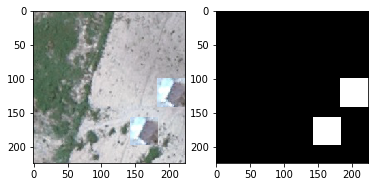

In [0]:
image_idx = random.randint(0, len(images)-1)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(images[image_idx])
axarr[1].imshow(masks[image_idx], cmap='gray')

## Training
### Train/Test Split

In [0]:
images = [preprocess_input(img) for img in images]
masks = [preprocess_input(msk) for msk in masks]

X_train = np.array(images[:300])
y_train = np.array(masks[:300])
X_val = np.array(images[300:])
y_val = np.array(masks[300:])

## Fitting model

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model.compile(optimizer=Adam(lr=0.01), loss=dice_coef_loss, metrics=[dice_coef])

earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
#mcp_save = ModelCheckpoint('./mdl_wts.h5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

In [0]:
hist = model.fit(X_train, y_train, batch_size=32, epochs=40,
          validation_data=(X_val, y_val), verbose=1, callbacks=[earlyStopping, reduce_lr_loss])

Train on 300 samples, validate on 200 samples
Epoch 1/40
300/300 [==============================] - 14s 46ms/step - loss: 0.1235 - dice_coef: 0.8765 - val_loss: 0.8856 - val_dice_coef: 0.1144
Epoch 2/40
300/300 [==============================] - 9s 30ms/step - loss: 0.0470 - dice_coef: 0.9530 - val_loss: 0.8861 - val_dice_coef: 0.1139
Epoch 3/40
300/300 [==============================] - 9s 30ms/step - loss: 0.0369 - dice_coef: 0.9631 - val_loss: 0.8860 - val_dice_coef: 0.1140
Epoch 4/40
300/300 [==============================] - 9s 30ms/step - loss: 0.0282 - dice_coef: 0.9718 - val_loss: 0.8858 - val_dice_coef: 0.1142
Epoch 5/40
300/300 [==============================] - 9s 30ms/step - loss: 0.0199 - dice_coef: 0.9801 - val_loss: 0.8856 - val_dice_coef: 0.1144
Epoch 6/40
300/300 [==============================] - 9s 30ms/step - loss: 0.0177 - dice_coef: 0.9823 - val_loss: 0.8851 - val_dice_coef: 0.1149
Epoch 7/40
300/300 [==============================] - 9s 29ms/step - loss: 0.0130 -

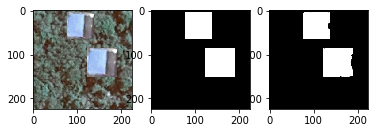

In [0]:
image_idx = random.randint(0, len(X_val)-1)
pred = model.predict(X_val[image_idx].reshape(1,INPUT_SIZE, INPUT_SIZE, 3))
f, axarr = plt.subplots(1,3)
axarr[0].imshow(X_val[image_idx])
axarr[1].imshow(y_val[image_idx], cmap='gray')
axarr[2].imshow(pred[0].reshape(224, 224), cmap='gray')

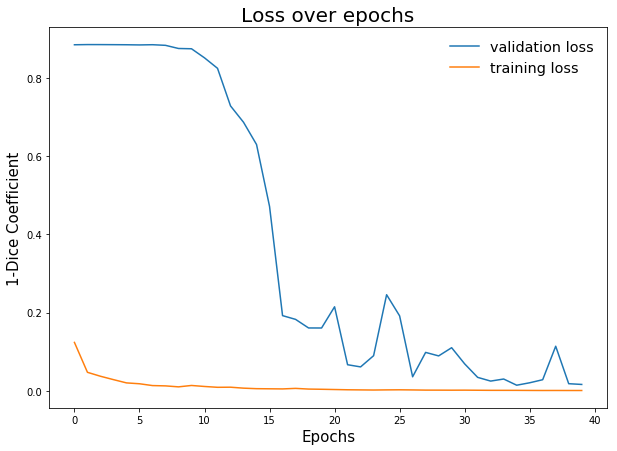

In [0]:
plt.figure(figsize=(10,7))
plt.plot(hist.history['val_loss'], label = 'validation loss')
plt.plot(hist.history['loss'], label = 'training loss')
plt.xlabel('Epochs', size=15)
plt.ylabel('1-Dice Coefficient', size=15)
plt.title('Loss over epochs', size=20)
plt.legend(frameon=False, fontsize='x-large');

In [0]:
from keras.models import load_model

In [0]:
model.save('pre_trained_model.h5')

In [0]:
new_model = load_model('pre_trained_model.h5', custom_objects={'dice_coef_loss':dice_coef_loss, 'dice_coef':dice_coef})

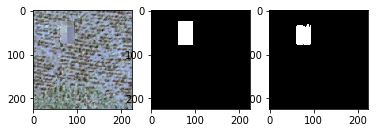

In [0]:
image_idx = random.randint(0, len(images)-1)
pred = new_model.predict(images[image_idx].reshape(1,INPUT_SIZE, INPUT_SIZE, 3))
f, axarr = plt.subplots(1,3)
axarr[0].imshow(images[image_idx])
axarr[1].imshow(masks[image_idx], cmap='gray')
axarr[2].imshow(pred[0].reshape(224, 224), cmap='gray')